In [1]:
# imports 
import pandas as pd
import glob
import numpy as np 
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

### make plots for the residual community

In [2]:
# read in the metadata
residual_community_metadata = pd.read_csv('../metadata//residual_community_metadata.csv')
order_dict = dict(zip(residual_community_metadata['FAME ID (leave blank)'], residual_community_metadata['Order'] ))

In [3]:
# read in the number of reads 
count_files = glob.glob('../data/prinseq_pass_counts/residual_community/*.counts')
counts = [pd.read_csv(c).columns[0] for c in count_files]
sample = [re.split('/', c)[-1][:10] for c in count_files]
count_dict = dict(zip(sample, counts))

In [4]:
# first residual community 
bracken_species_files = glob.glob('../data/bracken/residual_community/species_confidence_*/*.bracken')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples, 'portion': bracken_species_portion, 'count': bracken_species_counts})
residual_species_rarefaction['order'] = [order_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('order')

Text(0, 0.5, 'Number of Species Identified')

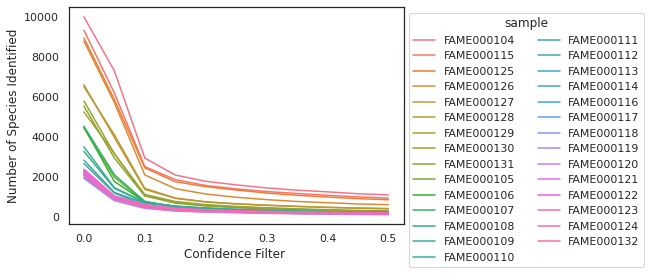

In [5]:
# plot species data 
plot_df = residual_species_rarefaction
sns.set(style="white", font_scale=1.0)

ax = sns.lineplot(data = plot_df,  y='count', x = 'portion', hue = 'sample')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.xlabel('Confidence Filter ')
plt.ylabel('Number of Species Identified')


In [6]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/residual_community/genus_confidence_*/*')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples, 'portion': bracken_genus_portion, 'count': bracken_genus_counts})
residual_genus_rarefaction['order'] = [order_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('order')

Text(0, 0.5, 'Number of Genera Identified')

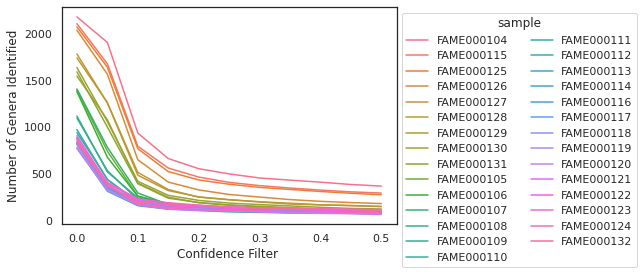

In [7]:
# plot curves 
plot_df = residual_genus_rarefaction

sns.set(style="white", font_scale=1.0)
ax = sns.lineplot(data = plot_df,  y='count', x = 'portion', hue = 'sample')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.xlabel('Confidence Filter ')
plt.ylabel('Number of Genera Identified')


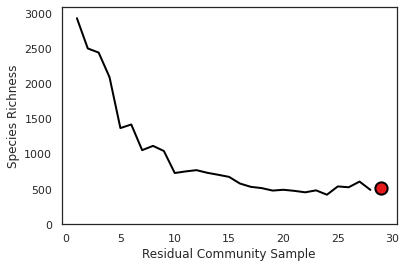

In [8]:
# set the confidence level to 0.1 
confidence_plot = residual_species_rarefaction[residual_species_rarefaction['portion'] == 0.1]

plt.figure(figsize=(6, 4))
sns.set(style="white", font_scale=1.0)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'order', y = 'count', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'order', y = 'count', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
plt.ylim((0,3100))
plt.xlabel('Residual Community Sample')
plt.ylabel('Species Richness')

# Save the figure to a file
plt.savefig('species_richness_plot.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-9-12ca56abd8c4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  confidence_plot = residual_genus_rarefaction[residual_species_rarefaction['portion'] == 0.1]


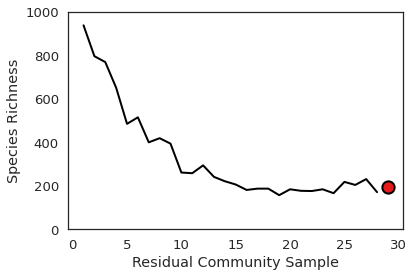

In [9]:
# set the confidence level to 0.1 
confidence_plot = residual_genus_rarefaction[residual_species_rarefaction['portion'] == 0.1]

sns.set(style="white", font_scale=1.2)
sns.lineplot(data = confidence_plot[confidence_plot['order'] != 29].drop_duplicates(), x = 'order', y = 'count', linewidth=2, color = 'black')
sns.scatterplot(data = confidence_plot[confidence_plot['order'] == 29].drop_duplicates(), x = 'order', y = 'count', color = '#e41a1c', s = 150,  edgecolor='black', linewidth=2)
plt.ylim((0,1000))
plt.xlabel('Residual Community Sample')
plt.ylabel('Species Richness')

# Save the figure to a file
plt.savefig('species_richness_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## take a confidence level of 0.1 and then apply this to build rarefaction curves

In [24]:
# first residual community 
#bracken_species_files = glob.glob('/home/grig0076/scratch/TubePaper_2023/residual_community_Tube_fastq/krakefaction_paired_trimnami_2024/confidence_0.1/repeat/*.bracken')
bracken_species_files = glob.glob('../data/bracken/residual_community/rarefaction_confidence_0.1/*.bracken.species')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0] 
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd = dd[dd['new_est_reads'] > 0] # only include the reads that are present 
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1) # is there an other option or something here 

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples,'count': bracken_species_counts, 'portion': bracken_species_portion})
residual_species_rarefaction['order'] = [order_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('order')

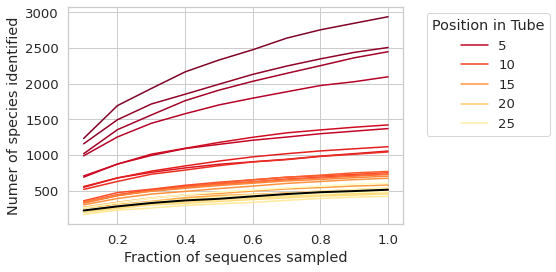

In [25]:
sns.set(font_scale=1.2, style = 'whitegrid')
sns.lineplot(data = residual_species_rarefaction[residual_species_rarefaction['order'] < 29], x = 'portion', y = 'count', hue = 'order', palette = 'YlOrRd_r')
sns.lineplot(data = residual_species_rarefaction[residual_species_rarefaction['order'] == 29], x = 'portion', y = 'count', color = 'black', linewidth=2, dashes = True)

plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Numer of species identified')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Position in Tube')

In [26]:
bracken_species_table.to_csv('../output_files/residual_community_bracken_species_confidence_0.1.tsv', sep = '\t')

In [20]:
## Need to delete the output with the stacked flags 

In [21]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/residual_community/rarefaction_confidence_0.1/*.bracken.genus')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples,'count': bracken_genus_counts, 'portion': bracken_genus_portion})
residual_genus_rarefaction['order'] = [order_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('order')

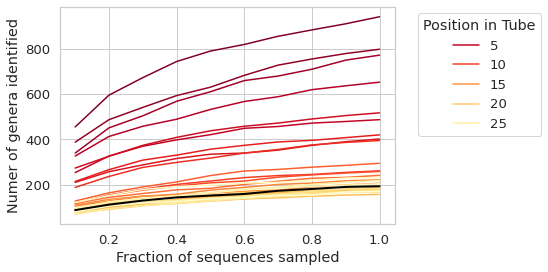

In [22]:
sns.set(font_scale=1.2, style = 'whitegrid')
sns.lineplot(data = residual_genus_rarefaction[residual_genus_rarefaction['order'] < 29], x = 'portion', y = 'count', hue = 'order', palette = 'YlOrRd_r')
sns.lineplot(data = residual_genus_rarefaction[residual_genus_rarefaction['order'] == 29], x = 'portion', y = 'count', color = 'black', linewidth=2, dashes = True)

plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Numer of genera identified')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title = 'Position in Tube')

In [23]:
bracken_species_table.to_csv('../output_files/residual_community_bracken_genus_confidence_0.1.tsv', sep = '\t')

### Investigate the rare taxa 

FAME000104: number of rare taxa: 2896
FAME000115: number of rare taxa: 2461
FAME000125: number of rare taxa: 2402
FAME000126: number of rare taxa: 2057
FAME000127: number of rare taxa: 1351
FAME000128: number of rare taxa: 1404
FAME000129: number of rare taxa: 1037
FAME000130: number of rare taxa: 1101
FAME000131: number of rare taxa: 1029
FAME000105: number of rare taxa: 714
FAME000106: number of rare taxa: 735
FAME000107: number of rare taxa: 756
FAME000108: number of rare taxa: 718
FAME000109: number of rare taxa: 689
FAME000110: number of rare taxa: 662
FAME000111: number of rare taxa: 572
FAME000112: number of rare taxa: 526
FAME000113: number of rare taxa: 508
FAME000114: number of rare taxa: 474
FAME000116: number of rare taxa: 485
FAME000117: number of rare taxa: 469
FAME000118: number of rare taxa: 449
FAME000119: number of rare taxa: 476
FAME000120: number of rare taxa: 415
FAME000121: number of rare taxa: 533
FAME000122: number of rare taxa: 522
FAME000123: number of rare ta

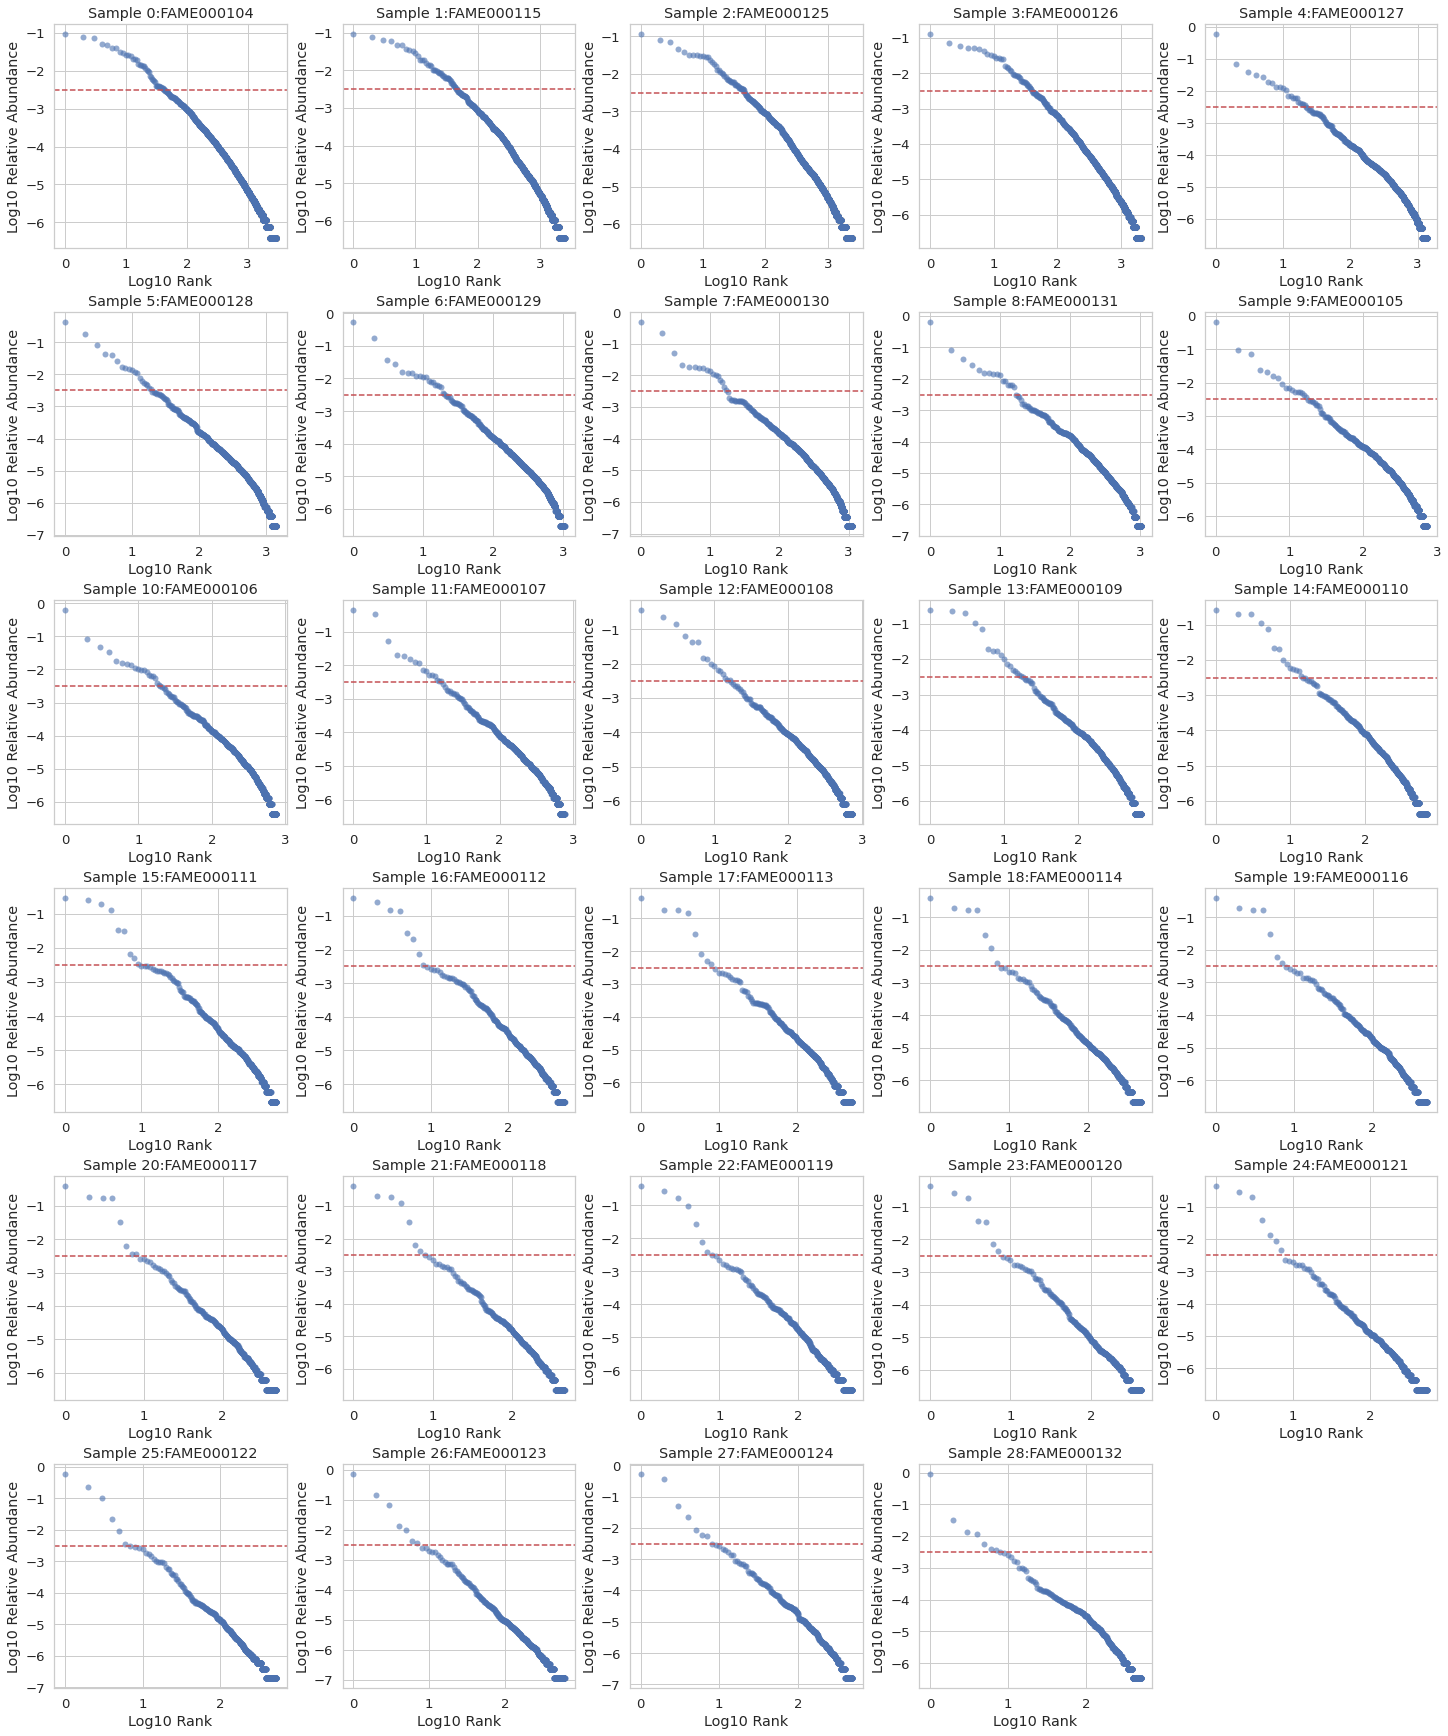

In [27]:
samples = list(order_dict.keys()) 
num_rare_taxa = [] 
bracken_species_table_abund = bracken_species_table / bracken_species_table.sum() 

num_samples = len(samples)
num_cols = 5  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_samples / num_cols))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)

for idx, f in enumerate(samples): 
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    this_sample = bracken_species_table_abund[[f]] 
    this_sample = this_sample[this_sample[f] != 0].sort_values(f, ascending=False)
    this_sample['rank'] = [i + 1 for i in range(len(this_sample))]
    this_sample['rank_log'] = np.log10(this_sample['rank']) 
    this_sample[f + '_log'] = np.log10(this_sample[f])

    sns.scatterplot(data=this_sample, x='rank_log', y=f + '_log', linewidth=0, alpha=0.6, ax=ax)
    ax.axhline(y=-2.5, color='r', linestyle='--')  # Adding dashed line at y=-2.5

    ax.set_xlabel('Log10 Rank')
    ax.set_ylabel('Log10 Relative Abundance')
    ax.set_title(f'Sample {idx}:{f}')

    num_rare = len(this_sample[this_sample[f + '_log'] < -2.5])
    print(f + ': number of rare taxa: ' + str(num_rare))
    num_rare_taxa.append(num_rare) 

# Hide any unused subplots
for idx in range(num_samples, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

    
plt.savefig('species_abundance_plots.png') 

plt.show()

num_rare_tax_dict = dict(zip(samples, num_rare_taxa))

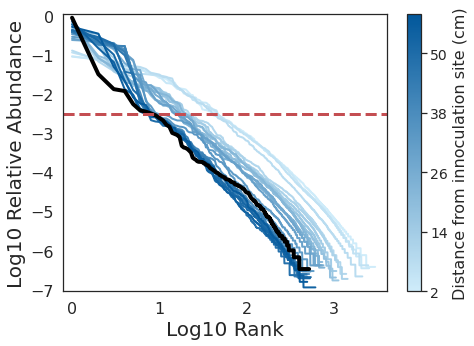

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a gradient color map from light to dark
cmap = LinearSegmentedColormap.from_list("gradient", ["#CFECFA", "#01579B"])

# Create a wider figure
fig, ax = plt.subplots(figsize=(7, 5))  # Increased width for better layout
sns.set(style="white", font_scale=1.2)

# Normalize sample indices to map them to the color gradient
norm = plt.Normalize(vmin=0, vmax=len(samples) - 1)

# Plot each sample
for idx, f in enumerate(samples):
    this_sample = bracken_species_table_abund[[f]]
    this_sample = this_sample[this_sample[f] != 0].sort_values(f, ascending=False)
    this_sample['rank'] = [i + 1 for i in range(len(this_sample))]
    this_sample['rank_log'] = np.log10(this_sample['rank'])
    this_sample[f + '_log'] = np.log10(this_sample[f])

    # Map index to color
    if idx == len(samples) - 1:  # Last sample
        color = 'black'
        linewidth = 4  # Thicker line for the last sample
        label = f  # Last sample label
    else:
        color = cmap(norm(idx))
        linewidth = 2
        label = f  # Label for other samples

    # Plot line
    sns.lineplot(data=this_sample, x='rank_log', y=f + '_log', ax=ax, color=color, linewidth=linewidth, label=label, legend=False)

# Set labels and limits
ax.axhline(y=-2.5, color='r', linestyle='--', linewidth=3) 
ax.set_xlim((-0.1, 3.6))
ax.set_ylim((bracken_species_table_abund.apply(lambda x: np.log10(x[x != 0].min())).min() - 0.1, 
             bracken_species_table_abund.apply(lambda x: np.log10(x.max())).max() + 0.1))
ax.set_xlabel('Log10 Rank', fontsize=20)
ax.set_ylabel('Log10 Relative Abundance', fontsize=20)

# Increase the size of x and y ticks
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Create a colorbar as a gradient key
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")

# Generate rounded tick values
rounded_ticks = np.arange(0, len(samples) + 1, step=round(len(samples) / 5))  # Adjust the step for spacing
transformed_ticks = 2 * (rounded_ticks + 1)

# Set the ticks and labels to be more rounded numbers
cbar.set_ticks(rounded_ticks)
cbar.set_ticklabels([f'{int(tick)}' for tick in transformed_ticks])

cbar.set_label('Distance from innoculation site (cm)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent white space
plt.subplots_adjust(right=0.75)  # Adjust the right margin to fit the colorbar
plt.tight_layout()
plt.savefig('../output_files/species_abundance_combined.png', dpi=300)
plt.show()


### Make plots for long-term migration

In [36]:
long_term_metadata = pd.read_csv('../metadata/long_term_migration_metadata.csv')
location_dict = dict(zip(long_term_metadata['FAME'], long_term_metadata['location']))

In [43]:
# read in the number of reads 
count_files = glob.glob('../data/prinseq_pass_counts/long_term_migration/prinseq_pass_counts/*.counts')
counts = [pd.read_csv(c).columns[0] for c in count_files]
sample = [re.split('/', c)[-1][:10] for c in count_files]
count_dict = dict(zip(sample, counts))

In [47]:
# long term migration 
bracken_species_files = glob.glob('../data/bracken/long_term_migration/species_confidence_*/*bracken' )
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples, 'portion': bracken_species_portion, 'count': bracken_species_counts})
residual_species_rarefaction['location'] = [location_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('location')

Text(0, 0.5, 'Number of Species Identified')

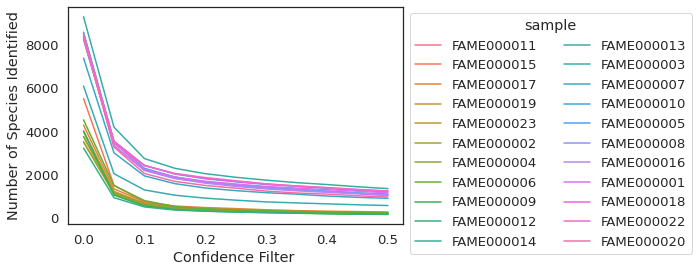

In [48]:
# plot species data 
plot_df = residual_species_rarefaction

ax = sns.lineplot(data = plot_df,  y='count', x = 'portion', hue = 'sample')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.xlabel('Confidence Filter ')
plt.ylabel('Number of Species Identified')

In [49]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/long_term_migration/genus_confidence_*/*bracken.genus' )
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [ float(re.split('_', re.split('/', g)[-2])[-1]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples, 'portion': bracken_genus_portion, 'count': bracken_genus_counts})
residual_genus_rarefaction['location'] = [location_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('location')

Text(0, 0.5, 'Number of Genera Identified')

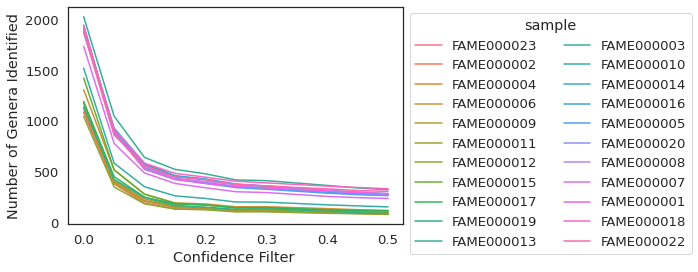

In [50]:
# plot species data 
plot_df = residual_genus_rarefaction

ax = sns.lineplot(data = plot_df,  y='count', x = 'portion', hue = 'sample')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.xlabel('Confidence Filter ')
plt.ylabel('Number of Genera Identified')

In [51]:
# first residual community 
bracken_genus_files = glob.glob('../data/bracken/long_term_migration/rarefaction_confidence_0.1/*.bracken.genus')
bracken_genus_samples = [re.split('/', g)[-1][:10] for g in bracken_genus_files]
bracken_genus_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_genus_files]

bracken_genus_counts = []
bracken_genus_table = pd.DataFrame()
for t in bracken_genus_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_genus_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_genus_table = pd.concat([bracken_genus_table,dd], axis = 1)

residual_genus_rarefaction = pd.DataFrame({'sample': bracken_genus_samples,'count': bracken_genus_counts, 'portion': bracken_genus_portion})
residual_genus_rarefaction['location'] = [location_dict.get(g) for g in residual_genus_rarefaction['sample']]
residual_genus_rarefaction = residual_genus_rarefaction.sort_values('location')

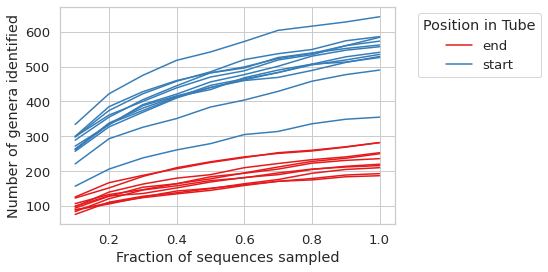

In [52]:

# Adjust the font scale and style
sns.set(font_scale=1.2, style='whitegrid')

# Define a custom color palette
custom_palette = {
    'end': '#e41a1c',
    'start': '#377eb8'
}

# Create the lineplot
sns.lineplot(data=residual_genus_rarefaction, x='portion', y='count', hue='location', style='sample', dashes=False, palette=custom_palette)

# Set the labels
plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Number of genera identified')

# Adjust the legend to only show 'location'
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = sorted(set(labels))
location_handles = [handles[labels.index(label)] for label in unique_labels if label in custom_palette.keys()]
location_labels = sorted(custom_palette.keys())

# Create a new legend with only 'location'
plt.legend(location_handles, location_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Position in Tube')

# Show the plot
plt.show()


In [53]:
# first residual community 
bracken_species_files = glob.glob('../data/bracken/long_term_migration/rarefaction_confidence_0.1/*.bracken.species')
bracken_species_samples = [re.split('/', g)[-1][:10] for g in bracken_species_files]
bracken_species_portion = [float(re.split('report.', re.split('/', g)[-1])[1][:3]) for g in bracken_species_files]

bracken_species_counts = []
bracken_species_table = pd.DataFrame()
for t in bracken_species_files:
    table = pd.read_csv(t, sep = '\t') 
    
    # remove viruses from this table 
    table = table[~table['name'].str.contains('virus')]
    
    # only consider entries with more than 0 present 
    table = table[table['new_est_reads'] > 0]
    
    bracken_species_counts.append(len(table))
    
    if '.01.0.' in t:
        dd = table[['name', 'new_est_reads']].set_index('name')
        dd.columns = [re.split('/', t)[-1][:10]] 
        bracken_species_table = pd.concat([bracken_species_table,dd], axis = 1)

residual_species_rarefaction = pd.DataFrame({'sample': bracken_species_samples,'count': bracken_species_counts, 'portion': bracken_species_portion})
residual_species_rarefaction['location'] = [location_dict.get(g) for g in residual_species_rarefaction['sample']]
residual_species_rarefaction = residual_species_rarefaction.sort_values('location')

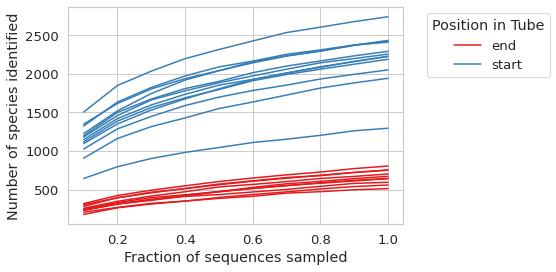

In [54]:
# Adjust the font scale and style
sns.set(font_scale=1.2, style='whitegrid')

# Define a custom color palette
custom_palette = {
    'end': '#e41a1c',
    'start': '#377eb8'
}

# Create the lineplot
sns.lineplot(data=residual_species_rarefaction, x='portion', y='count', hue='location', style='sample', dashes=False, palette=custom_palette)

# Set the labels
plt.xlabel('Fraction of sequences sampled')
plt.ylabel('Number of species identified')

# Adjust the legend to only show 'location'
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = sorted(set(labels))
location_handles = [handles[labels.index(label)] for label in unique_labels if label in custom_palette.keys()]
location_labels = sorted(custom_palette.keys())

# Create a new legend with only 'location'
plt.legend(location_handles, location_labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Position in Tube')

# Show the plot
plt.show()

In [55]:
residual_species_rarefaction[residual_species_rarefaction['portion'] == 1.0].sort_values('count', axis=0, ascending = False)

,sample,count,portion,location
120,FAME000013,2741,1.0,start
90,FAME000010,2434,1.0,start
170,FAME000018,2425,1.0,start
200,FAME000022,2411,1.0,start
40,FAME000005,2293,1.0,start
130,FAME000014,2257,1.0,start
0,FAME000001,2230,1.0,start
150,FAME000016,2225,1.0,start
70,FAME000008,2190,1.0,start
190,FAME000020,2052,1.0,start


In [56]:
residual_genus_rarefaction[residual_genus_rarefaction['portion'] == 1.0].sort_values('count', axis=0, ascending = False)

,sample,count,portion,location
120,FAME000013,643,1.0,start
170,FAME000018,586,1.0,start
150,FAME000016,584,1.0,start
90,FAME000010,573,1.0,start
200,FAME000022,562,1.0,start
70,FAME000008,557,1.0,start
40,FAME000005,541,1.0,start
190,FAME000020,535,1.0,start
0,FAME000001,529,1.0,start
130,FAME000014,526,1.0,start


# Rank abundance curves
Make some rank abundance curves to support the output 

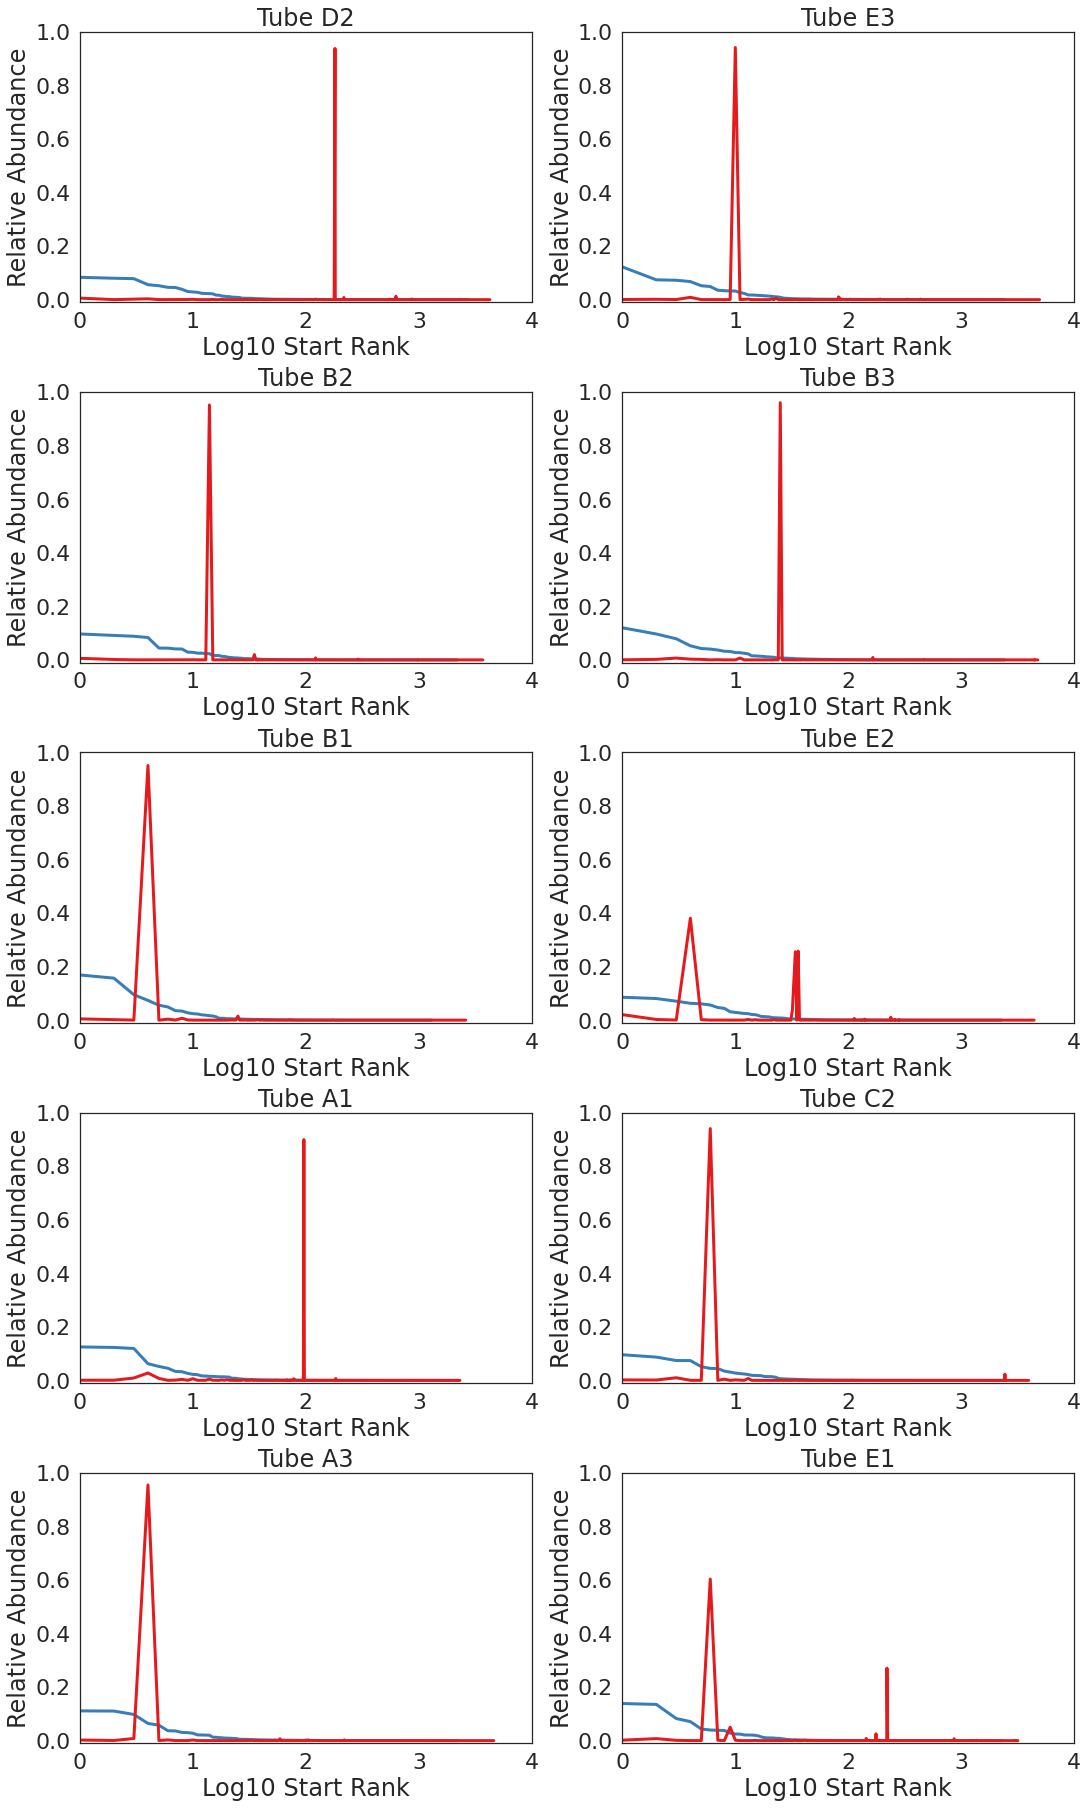

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tubes = list(set(long_term_metadata['tube'])) 
norm_abund = bracken_species_table / bracken_species_table.sum()

# Set the figure size 
sns.set(style="white", font_scale=2.0)

num_tubes = len(tubes) - 2
num_cols = 2  # Number of columns in the subplot grid
num_rows = int(np.ceil(num_tubes / num_cols))  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)

for idx, t in enumerate([t for t in tubes if t not in ['D3', 'A2']]): 
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    # Get the samples that are in this tube 
    tube_samples = long_term_metadata[long_term_metadata['tube'] == t]['FAME'].to_list() 
    if len(tube_samples) > 1: 
        tube_samples_location = [location_dict.get(f) for f in tube_samples]
        start_tube = tube_samples[tube_samples_location.index('start')] 
        end_tube = tube_samples[tube_samples_location.index('end')] 
        
        # Make rank abundance table 
        tube_abundances = norm_abund[[start_tube, end_tube]].sort_values(start_tube, ascending=False) 
        tube_abundances['start_rank'] = [i + 1 for i in range(len(tube_abundances))]
        tube_abundances['start_rank_log'] = np.log10(tube_abundances['start_rank'])
        
        # Log transform the abundances 
        tube_abundances[start_tube + '_log'] = np.log10(tube_abundances[start_tube])
        tube_abundances[end_tube + '_log'] = np.log10(tube_abundances[end_tube])
        
        sns.lineplot(data=tube_abundances, x='start_rank_log', y=start_tube, ax=ax, linewidth=3, color = '#377eb8')
        sns.lineplot(data=tube_abundances, x='start_rank_log', y=end_tube, ax=ax, linewidth=3, color = '#e41a1c')
        
        ax.set_xlabel('Log10 Start Rank')
        ax.set_ylabel('Relative Abundance')
        ax.set_xlim(0, 4)
        ax.set_ylim(-0.01, 1)
        ax.set_title(f'Tube {t}')
    else:
        print(t)
        ax.set_visible(False)  # Hide the unused subplot

# Hide any unused subplots
for idx in range(num_tubes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

# Save the figure as a PNG file
plt.savefig('tube_abundance_plots.png')

plt.show()
